This notebook cleans the data from the tidy file. It produces a list of prolific IDs that we want to exclude for each task.

In [1]:
# !pip install seaborn


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
import itertools


# Import data
- all thresholds: df_both_sessions

In [3]:
df_both_sessions = pd.read_csv('tidy_both_sessions_thresholds_log.csv')

In [4]:
num_thresholds_per_subj = 18
assert df_both_sessions["prolificID"].nunique() == len(df_both_sessions) / num_thresholds_per_subj, 'Fatal: Number of thresholds per subject does not match'

print(f'\nNumber of participants with both sessions: {df_both_sessions["prolificID"].nunique()}')


Number of participants with both sessions: 169


In [5]:
# Update meridian values for reading tasks
df_both_sessions.loc[
    (df_both_sessions['taskName'] == 'reading') & 
    (df_both_sessions['meridian'].isin(['Beaver', 'Desert'])),
    'meridian'
] = 'first'

df_both_sessions.loc[
    (df_both_sessions['taskName'] == 'reading') & 
    (df_both_sessions['meridian'].isin(['Winter', 'Islands'])),
    'meridian'
] = 'second'

# Data cleaning

## Filter participants based on the quality of individual thresholds
Exclude participants with:
- acuity and crowding: numTrialsSent < 35, questSD > 0.1
- rsvp: numTrialsSent < 24, questSD > 0.1
- ordinary reading: accuracy < 60

Outputs: prolificID of participants excluded based on each criteria. 
- {taskName}_low_trial_ids
- {taskName}_large_questSD_ids
- reading_low_accuracy_ids

In [6]:
num_trials_required = 35  # 35 trials for original staircase

acuity_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["acuity"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(acuity_low_trial_ids)}')

acuity_large_questSD_ids = (
	df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["acuity"]) & (df_both_sessions["questSD"] > 0.1),
        "prolificID"
	]
    .unique()
)
print(f'Number of participants with at least 1 threshold with questSD > 0.1: {len(acuity_large_questSD_ids)}')


Number of participants with at least 1 threshold with number of trials < 35: 16
Number of participants with at least 1 threshold with questSD > 0.1: 3


In [7]:
num_trials_required = 35  # 35 trials for original staircase

crowding_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["crowding"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(crowding_low_trial_ids)}')

crowding_large_questSD_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["crowding"]) & (df_both_sessions["questSD"] > 0.1),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with questSD > 0.1: {len(crowding_large_questSD_ids)}')


Number of participants with at least 1 threshold with number of trials < 35: 22
Number of participants with at least 1 threshold with questSD > 0.1: 28


In [8]:
num_trials_required = 24  # 24 trials for original staircase

rsvp_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["rsvp"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(rsvp_low_trial_ids)}')

rsvp_large_questSD_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["rsvp"]) & (df_both_sessions["questSD"] > 0.1),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with questSD > 0.1: {len(rsvp_large_questSD_ids)}')


Number of participants with at least 1 threshold with number of trials < 24: 0
Number of participants with at least 1 threshold with questSD > 0.1: 11


In [9]:
reading_low_accuracy_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["reading"]) & (df_both_sessions["readingCQAccuracy"] < 60),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 measurement with accuracy < 60%: {len(reading_low_accuracy_ids)}')


Number of participants with at least 1 measurement with accuracy < 60%: 63


## Compute the geometric mean of thresholds
- within the same block (one threshold per block): df_gmean_block
- across blocks for each task (one threshold per task): df_gmean_task
- within the same meridian (one threshold per meridian): df_gmean_meridian
- all data are logged so we can simply take the mean

In [10]:
# Group by participant, task, and repeat
df_gmean_block = (
    df_both_sessions.groupby(["prolificID", "taskName", "repeat"], observed=True)
					.agg(gmean_threshold_block=("threshold", lambda x: np.mean(x.dropna())))
					.reset_index()
)
df_gmean_block

,prolificID,taskName,repeat,gmean_threshold_block
0,559ad287fdf99b219a612d22,acuity,1,-0.415187
1,559ad287fdf99b219a612d22,acuity,2,-0.480609
2,559ad287fdf99b219a612d22,crowding,1,0.845687
3,559ad287fdf99b219a612d22,crowding,2,0.882659
4,559ad287fdf99b219a612d22,crowding,3,0.950354
...,...,...,...,...
1685,67fffee26ec983c07f3a2abd,crowding,4,0.140155
1686,67fffee26ec983c07f3a2abd,reading,1,2.102490
1687,67fffee26ec983c07f3a2abd,reading,2,2.279796
1688,67fffee26ec983c07f3a2abd,rsvp,1,2.543958


In [11]:
# Group by participant, task, and repeat
df_gmean_task = (
    df_both_sessions.groupby(["prolificID", "taskName"], observed=True)
					.agg(gmean_threshold_task=("threshold", lambda x: np.mean(x.dropna())))
					.reset_index()
)
df_gmean_task

,prolificID,taskName,gmean_threshold_task
0,559ad287fdf99b219a612d22,acuity,-0.447898
1,559ad287fdf99b219a612d22,crowding,0.929865
2,559ad287fdf99b219a612d22,reading,2.278744
3,559ad287fdf99b219a612d22,rsvp,2.633234
4,55d51a6b8ce09000127d4821,acuity,-0.633734
...,...,...,...
671,67e461f383bb0fc948ffd5fd,rsvp,3.175839
672,67fffee26ec983c07f3a2abd,acuity,-0.476663
673,67fffee26ec983c07f3a2abd,crowding,0.352948
674,67fffee26ec983c07f3a2abd,reading,2.191143


In [12]:
# Group by participant, task, and repeat
df_gmean_meridian = (
    df_both_sessions.groupby(["prolificID", "taskName","meridian"], observed=True)
					.agg(gmean_threshold_meridian=("threshold", lambda x: np.mean(x.dropna())))
					.reset_index()
)
df_gmean_meridian

,prolificID,taskName,meridian,gmean_threshold_meridian
0,559ad287fdf99b219a612d22,acuity,L8,-0.415579
1,559ad287fdf99b219a612d22,acuity,R8,-0.480217
2,559ad287fdf99b219a612d22,crowding,L8,1.094984
3,559ad287fdf99b219a612d22,crowding,R8,0.764746
4,559ad287fdf99b219a612d22,reading,first,2.311957
...,...,...,...,...
1178,67fffee26ec983c07f3a2abd,crowding,L8,0.504142
1179,67fffee26ec983c07f3a2abd,crowding,R8,0.201753
1180,67fffee26ec983c07f3a2abd,reading,first,2.276611
1181,67fffee26ec983c07f3a2abd,reading,second,2.105675


## Filter participants based on test-retest ratio
- log(test/retest), i.e., log(test) - log(retest), note: not the ratio of the logged thresholds; take the ratio between the numerical thresholds and then take the log.
- if test and retest are very different, then it means that the participant is unreliable and therefore should be excluded 

Outputs: prolificID of participants with large test-retest ratio
- {taskName}_bad_ratio_ids

### Functions:

In [13]:
def compute_test_retest_ratio(df, block1_colname, block2_colname):
	'''
	Compute test-retest ratio: log10(block2 / block1)
    Since the data are already log-transformed, the results would be equivalent to:
    block2 - block1
	'''
	return df[block2_colname] - df[block1_colname]

def flag_outliers_IQR(
    df,
    col_prefix="log_ratio_",
    criterion_k=1.5,
    verbose=True,
):
    """
    Add boolean outlier flags to ratio columns in a pivot table.

    - Detects columns via `col_prefix`.
    - For each ratio col: computes Q1, Q3, IQR; flags values < Q1 - k*IQR or > Q3 + k*IQR.
    - Writes a boolean flag column '<ratio_col>_is_outlier'.
    Returns a new DataFrame (does not modify input).
    """
    df = df.copy()

    # Identify ratio columns
    colNames = [c for c in df.columns if c.startswith(col_prefix)]

    for col in colNames:
        # Compute IQR bounds (NaNs ignored by quantile)
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - criterion_k * iqr
        upper = q3 + criterion_k * iqr

        mask = (df[col] < lower) | (df[col] > upper)
        out_col = f"{col}_is_outlier"
        df[out_col] = mask.fillna(False)

        if verbose:
            n = int(mask.sum())
            print(f"{col}: Q1={q1:.4f}, Q3={q3:.4f}, IQR={iqr:.4f}, "
                  f"bounds=({lower:.4f}, {upper:.4f}), outliers={n}")

    return df


def exclusion_ids_from_flags(
    df_wide: pd.DataFrame,
    task: str,
    flag_cols=None,                 # e.g., ["log_ratio_2vs1_is_outlier"] or None → auto-pick all *_is_outlier
    require="any",                  # "any" = exclude if ANY flag True; "all" = exclude only if ALL flags True
):
    """
    Return a list of prolificID to exclude for a given task, based on boolean outlier flags.
    df_wide must include columns: 'prolificID', 'taskName', and *_is_outlier booleans.
    """
    d = df_wide[df_wide["taskName"] == task]

    if flag_cols is None:
        flag_cols = [c for c in d.columns if c.endswith("_is_outlier")]

    if not flag_cols:
        return []  # nothing to check

    if require == "any":
        bad = d.groupby("prolificID")[flag_cols].any().any(axis=1)
    elif require == "all":
        bad = d.groupby("prolificID")[flag_cols].all().all(axis=1)
    else:
        raise ValueError("Invalid require value. Use 'any' or 'all'.")
    return bad[bad].index.tolist()

def filter_excluding_ids(df_wide: pd.DataFrame, *exclude_lists):
    """
    Return df_wide with rows whose prolificID is NOT in any of the exclude lists.
    Accepts multiple lists/sets of IDs.
    """
    # Merge all input lists/sets into one set
    exclude_ids = set().union(*exclude_lists)
    return df_wide[~df_wide["prolificID"].isin(exclude_ids)].copy()

def filter_including_ids(df_wide: pd.DataFrame, *include_lists):
    """
    Return df_wide with rows whose prolificID IS IN any of the exclude lists.
    Accepts multiple lists/sets of IDs.
    """
    # Merge all input lists/sets into one set
    include_ids = set().union(*include_lists)
    return df_wide[df_wide["prolificID"].isin(include_ids)].copy()


In [14]:
def plot_ratio(data_array, title, num_bins=80, min_val=-2.5, max_val=2.5, abs_bool=False): # , num_bins=20, min_val=0.08, max_val=1.11
    '''
    Input:
    - data_array: an array of test-retest ratios
    - title: [string] title and x-axis label of the figure
    '''
    
    # make the bins look the same size on a log scale
    # min_val = round(np.nanmin(data_array),2)
    # max_val = round(np.nanmax(data_array),2)
    # print(f'Min and max bin limits: {min_val}, {max_val}')
    bins = np.linspace(min_val, max_val, num_bins + 1)
    if abs_bool:
        data_array = np.abs(data_array)
        title = 'Absolute ' + title
                
    plt.figure(figsize=(8, 2)) 
    plt.hist(data_array, bins=bins, color='lightyellow', edgecolor='black')# bins=bins
    plt.title(f"{title} (n = {np.count_nonzero(~np.isnan(data_array))})", fontsize = 16)
    plt.xlabel(title, fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)
    plt.xlim(min_val, max_val)
    # plt.ylim(0,100)
    # add ticks and format them as normal floats
    # tick_positions = np.linspace(0.1, 1, num=10)  
    # plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions])

    
    plt.show()

### Compute ratios:

In [15]:
df_gmean_block_wide = (df_gmean_block
        .pivot(index=["prolificID", "taskName"],
               columns="repeat",
               values="gmean_threshold_block")
        .rename(columns={1: "block1", 2: "block2", 3: "block3", 4: "block4"})
        .reset_index())

df_gmean_block_wide

repeat,prolificID,taskName,block1,block2,block3,block4
0,559ad287fdf99b219a612d22,acuity,-0.415187,-0.480609,NaN,NaN
1,559ad287fdf99b219a612d22,crowding,0.845687,0.882659,0.950354,1.040760
2,559ad287fdf99b219a612d22,reading,2.322498,2.234990,NaN,NaN
3,559ad287fdf99b219a612d22,rsvp,2.523579,2.742889,NaN,NaN
4,55d51a6b8ce09000127d4821,acuity,-0.596659,-0.670809,NaN,NaN
...,...,...,...,...,...,...
671,67e461f383bb0fc948ffd5fd,rsvp,3.190082,3.161596,NaN,NaN
672,67fffee26ec983c07f3a2abd,acuity,-0.398057,-0.555268,NaN,NaN
673,67fffee26ec983c07f3a2abd,crowding,0.532112,0.631514,0.108010,0.140155
674,67fffee26ec983c07f3a2abd,reading,2.102490,2.279796,NaN,NaN


In [16]:
df_gmean_block_wide['log_ratio_2vs1'] = compute_test_retest_ratio(df_gmean_block_wide, 'block1', 'block2')
df_gmean_block_wide['log_ratio_3vs1'] = compute_test_retest_ratio(df_gmean_block_wide, 'block1', 'block3')
df_gmean_block_wide['log_ratio_4vs1'] = compute_test_retest_ratio(df_gmean_block_wide, 'block1', 'block4')
df_gmean_block_wide['log_ratio_3vs2'] = compute_test_retest_ratio(df_gmean_block_wide, 'block2', 'block3')
df_gmean_block_wide['log_ratio_4vs2'] = compute_test_retest_ratio(df_gmean_block_wide, 'block2', 'block4')
df_gmean_block_wide['log_ratio_4vs3'] = compute_test_retest_ratio(df_gmean_block_wide, 'block3', 'block4')

In [17]:
display(df_gmean_block_wide)

repeat,prolificID,taskName,block1,block2,block3,block4,log_ratio_2vs1,log_ratio_3vs1,log_ratio_4vs1,log_ratio_3vs2,log_ratio_4vs2,log_ratio_4vs3
0,559ad287fdf99b219a612d22,acuity,-0.415187,-0.480609,NaN,NaN,-0.065422,NaN,NaN,NaN,NaN,NaN
1,559ad287fdf99b219a612d22,crowding,0.845687,0.882659,0.950354,1.040760,0.036972,0.104667,0.195073,0.067695,0.158101,0.090406
2,559ad287fdf99b219a612d22,reading,2.322498,2.234990,NaN,NaN,-0.087507,NaN,NaN,NaN,NaN,NaN
3,559ad287fdf99b219a612d22,rsvp,2.523579,2.742889,NaN,NaN,0.219310,NaN,NaN,NaN,NaN,NaN
4,55d51a6b8ce09000127d4821,acuity,-0.596659,-0.670809,NaN,NaN,-0.074150,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
671,67e461f383bb0fc948ffd5fd,rsvp,3.190082,3.161596,NaN,NaN,-0.028486,NaN,NaN,NaN,NaN,NaN
672,67fffee26ec983c07f3a2abd,acuity,-0.398057,-0.555268,NaN,NaN,-0.157210,NaN,NaN,NaN,NaN,NaN
673,67fffee26ec983c07f3a2abd,crowding,0.532112,0.631514,0.108010,0.140155,0.099403,-0.424102,-0.391956,-0.523505,-0.491359,0.032145
674,67fffee26ec983c07f3a2abd,reading,2.102490,2.279796,NaN,NaN,0.177307,NaN,NaN,NaN,NaN,NaN


### Plot ratios before filtering

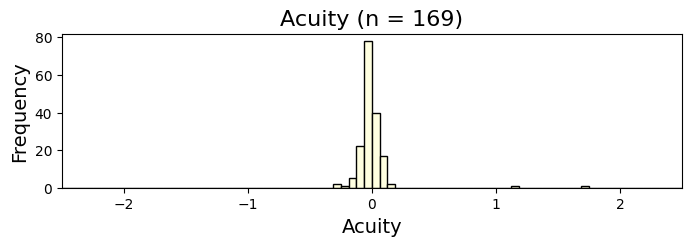

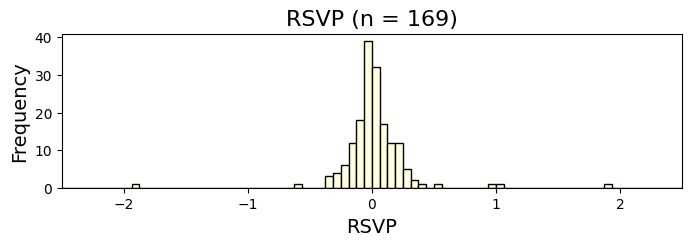

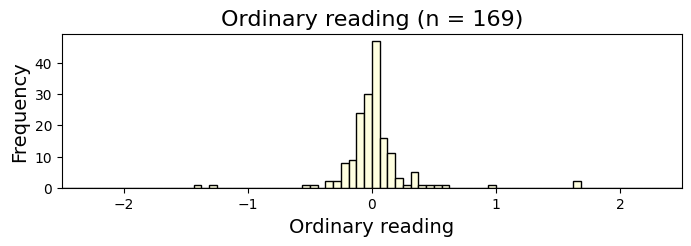

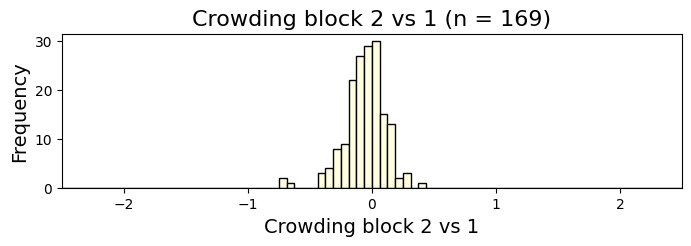

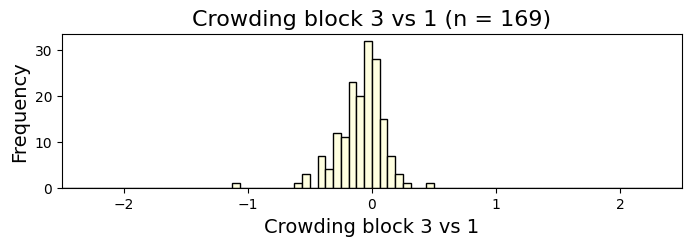

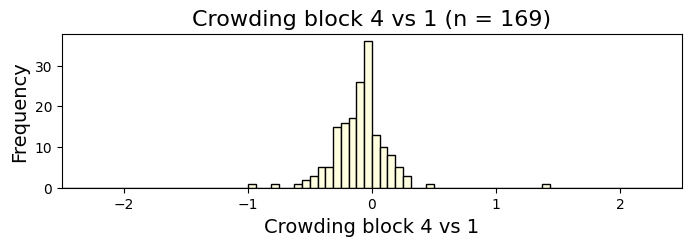

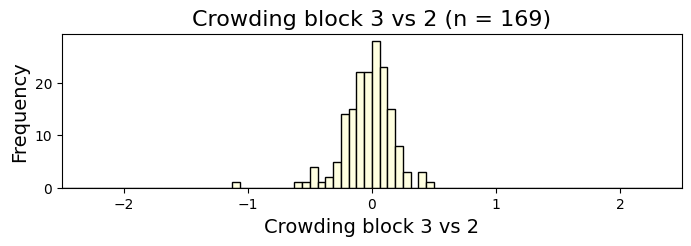

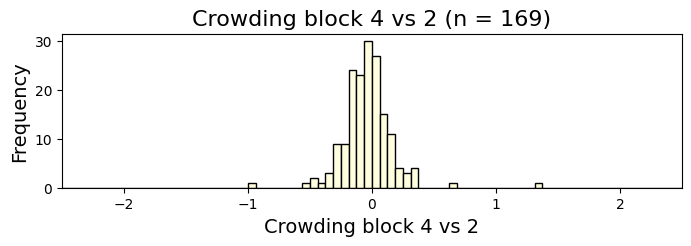

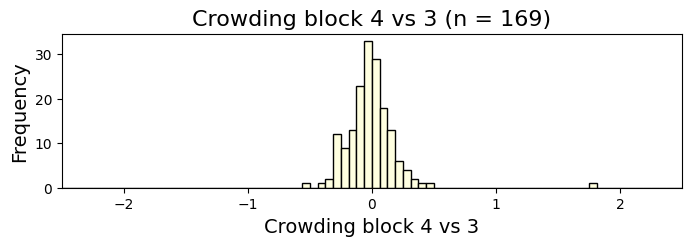

In [18]:
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "acuity"]['log_ratio_2vs1'], 'Acuity')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "rsvp"]['log_ratio_2vs1'], 'RSVP')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "reading"]['log_ratio_2vs1'], 'Ordinary reading')

plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_2vs1'], 'Crowding block 2 vs 1')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_3vs1'], 'Crowding block 3 vs 1')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_4vs1'], 'Crowding block 4 vs 1')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_3vs2'], 'Crowding block 3 vs 2')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_4vs2'], 'Crowding block 4 vs 2')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_4vs3'], 'Crowding block 4 vs 3')


### Flag outliers

In [19]:
df_gmean_block_wide_flaggedOutliers = df_gmean_block_wide.copy()
df_gmean_block_wide_flaggedOutliers = flag_outliers_IQR(df_gmean_block_wide_flaggedOutliers)

log_ratio_2vs1: Q1=-0.0792, Q3=0.0543, IQR=0.1335, bounds=(-0.2794, 0.2545), outliers=59
log_ratio_3vs1: Q1=-0.1719, Q3=0.0235, IQR=0.1954, bounds=(-0.4650, 0.3166), outliers=6
log_ratio_4vs1: Q1=-0.2062, Q3=-0.0020, IQR=0.2042, bounds=(-0.5126, 0.3043), outliers=6
log_ratio_3vs2: Q1=-0.1309, Q3=0.0897, IQR=0.2206, bounds=(-0.4618, 0.4206), outliers=7
log_ratio_4vs2: Q1=-0.1476, Q3=0.0505, IQR=0.1981, bounds=(-0.4447, 0.3477), outliers=6
log_ratio_4vs3: Q1=-0.1099, Q3=0.0722, IQR=0.1822, bounds=(-0.3832, 0.3454), outliers=5


In [20]:
display(df_gmean_block_wide_flaggedOutliers.head())

repeat,prolificID,taskName,block1,block2,block3,block4,log_ratio_2vs1,log_ratio_3vs1,log_ratio_4vs1,log_ratio_3vs2,log_ratio_4vs2,log_ratio_4vs3,log_ratio_2vs1_is_outlier,log_ratio_3vs1_is_outlier,log_ratio_4vs1_is_outlier,log_ratio_3vs2_is_outlier,log_ratio_4vs2_is_outlier,log_ratio_4vs3_is_outlier
0,559ad287fdf99b219a612d22,acuity,-0.415187,-0.480609,NaN,NaN,-0.065422,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,559ad287fdf99b219a612d22,crowding,0.845687,0.882659,0.950354,1.04076,0.036972,0.104667,0.195073,0.067695,0.158101,0.090406,False,False,False,False,False,False
2,559ad287fdf99b219a612d22,reading,2.322498,2.234990,NaN,NaN,-0.087507,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,559ad287fdf99b219a612d22,rsvp,2.523579,2.742889,NaN,NaN,0.219310,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4,55d51a6b8ce09000127d4821,acuity,-0.596659,-0.670809,NaN,NaN,-0.074150,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False


### List participants filtered out by test-retest ratios

In [21]:
# exclude all participants with any outlier in any of the crowding ratios
acuity_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='acuity', flag_cols=["log_ratio_2vs1_is_outlier"])
crowding_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding')
rsvp_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='rsvp', flag_cols=["log_ratio_2vs1_is_outlier"])
reading_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='reading', flag_cols=["log_ratio_2vs1_is_outlier"])

df_all_acuity = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "acuity"]
df_filtered_acuity = filter_excluding_ids(df_all_acuity, acuity_bad_ratio_ids)

df_all_rsvp = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "rsvp"]
df_filtered_rsvp = filter_excluding_ids(df_all_rsvp, rsvp_bad_ratio_ids)

df_all_reading = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "reading"]
df_filtered_reading = filter_excluding_ids(df_all_reading, reading_bad_ratio_ids)

# Below are exclusiong ids for individual crowding ratios. Created for plotting ratios after exclusion.
crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_2vs1_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding21 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_3vs1_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding31 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_4vs1_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding41 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_3vs2_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding32 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_4vs2_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding42 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_4vs3_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding43 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)


### Plot ratios after filtering

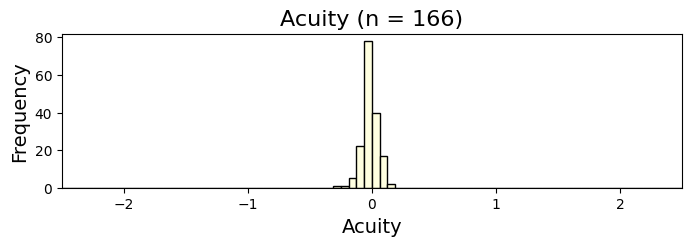

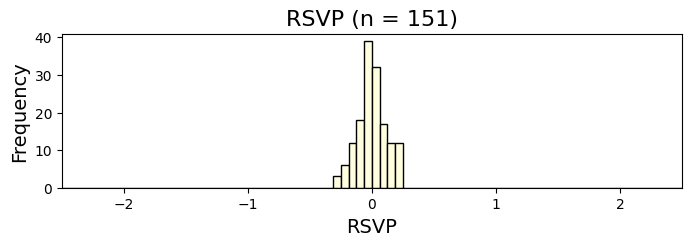

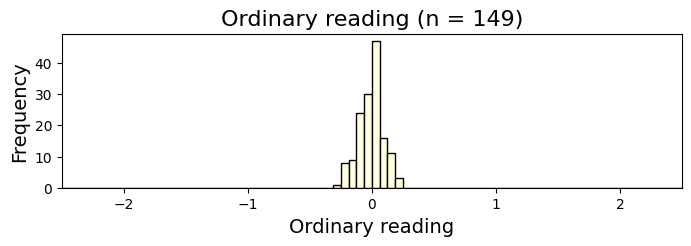

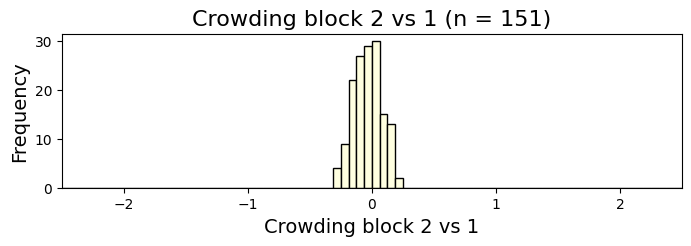

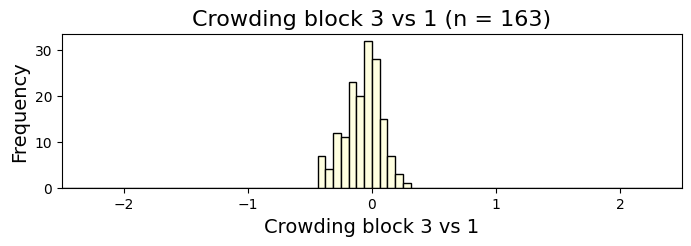

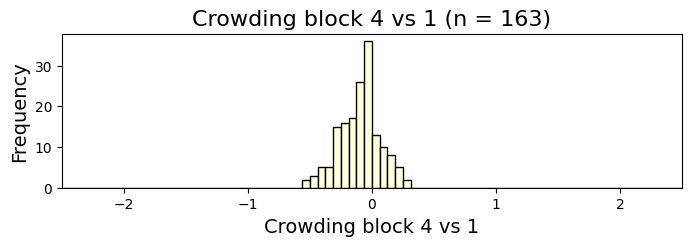

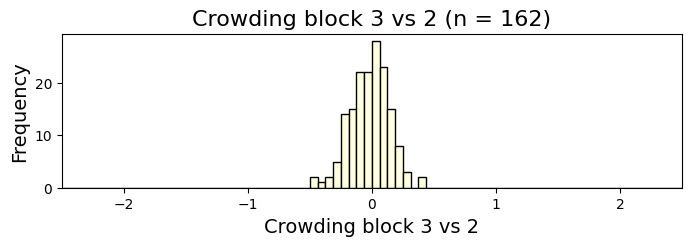

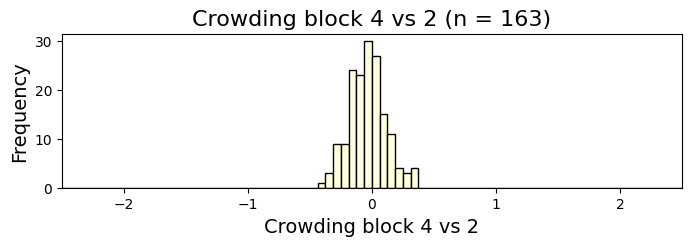

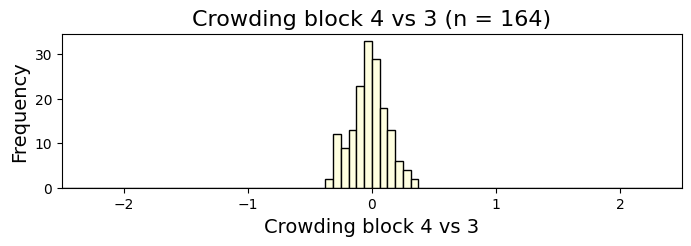

In [22]:
plot_ratio(df_filtered_acuity["log_ratio_2vs1"],title="Acuity")
plot_ratio(df_filtered_rsvp["log_ratio_2vs1"], title="RSVP")
plot_ratio(df_filtered_reading["log_ratio_2vs1"], title="Ordinary reading")

plot_ratio(df_filtered_crowding21["log_ratio_2vs1"], title="Crowding block 2 vs 1")
plot_ratio(df_filtered_crowding31["log_ratio_3vs1"], title="Crowding block 3 vs 1")
plot_ratio(df_filtered_crowding41["log_ratio_4vs1"], title="Crowding block 4 vs 1")
plot_ratio(df_filtered_crowding32["log_ratio_3vs2"], title="Crowding block 3 vs 2")
plot_ratio(df_filtered_crowding42["log_ratio_4vs2"], title="Crowding block 4 vs 2")
plot_ratio(df_filtered_crowding43["log_ratio_4vs3"], title="Crowding block 4 vs 3")

## Save the list of participants being excluded

In [23]:
# merge and deduplicate
acuity_exclude_ids = list(set(acuity_low_trial_ids) 
                          | set(acuity_large_questSD_ids) 
                          | set(acuity_bad_ratio_ids))

crowding_exclude_ids = list(set(crowding_low_trial_ids) 
                          | set(crowding_large_questSD_ids) 
                          | set(crowding_bad_ratio_ids))

rsvp_exclude_ids = list(set(rsvp_low_trial_ids) 
                          | set(rsvp_large_questSD_ids) 
                          | set(rsvp_bad_ratio_ids))

reading_exclude_ids = list(set(reading_low_accuracy_ids) 
                          | set(reading_bad_ratio_ids))

exclude_dict = {
    "acuity": acuity_exclude_ids,
    "crowding": crowding_exclude_ids,
    "reading": reading_exclude_ids,
    "rsvp": rsvp_exclude_ids
}

import json

with open("exclude_dict.json", "w") as f:
    json.dump(exclude_dict, f, indent=2)


# Filter data for analysis
- note that everything in is now logged

### Functions

In [24]:
def filter_task_df(df, taskName, 
                    low_trial_ids, large_questSD_ids, bad_ratio_ids):
    '''
    filter data by number of trials, questSD, and test-retest ratio for a given task.
    '''
    df_task_raw = df[df['taskName'] == taskName]
    df_cleaned = filter_excluding_ids(df_task_raw, low_trial_ids, large_questSD_ids, bad_ratio_ids)

    return df_cleaned

In [25]:
def make_task_wide(block_df, task_df, task_name):
    """
    block_df: columns ['prolificID','taskName','repeat','gmean_threshold_block']
    task_df : columns ['prolificID','taskName','repeat','gmean_threshold_task']
    returns: wide df with columns like ['prolificID', f'{task}_block1', ..., f'{task}_grandMean']
    """

    # 1) pivot blocks → one column per repeat
    wide_blocks = (block_df
                   .pivot(index="prolificID", columns="repeat", values="gmean_threshold_block")
                   .sort_index(axis=1))  # ensure block1, block2, ...

    # rename e.g. 1→'acuity_block1'
    wide_blocks.columns = [f"{task_name}_block{int(c)}" for c in wide_blocks.columns]

    # 2) grand mean per participant (use task_df; if multiple rows, average them)
    grand = (task_df
             .groupby("prolificID", as_index=True)["gmean_threshold_task"]
             .mean()
             .rename(f"{task_name}_grandMean")
             .to_frame())

    # combine and return
    out = wide_blocks.join(grand, how="outer").reset_index()
    return out


def build_big_df(task_to_dfs):
    """
    task_to_dfs: dict like {
        'acuity':   (acuity_gmean_block_cleaned_df,   acuity_gmean_task_cleaned_df),
        'crowding': (crowding_gmean_block_cleaned_df, crowding_gmean_task_cleaned_df),
        'rsvp':     (rsvp_gmean_block_cleaned_df,     rsvp_gmean_task_cleaned_df),
        'reading':  (reading_gmean_block_cleaned_df,  reading_gmean_task_cleaned_df),
    }
    returns one big df with prolificID rows and all task columns.
    """
    pieces = []
    for task, (block_df, task_df) in task_to_dfs.items():
        w = make_task_wide(block_df, task_df, task)
        pieces.append(w.set_index("prolificID"))

    big = pd.concat(pieces, axis=1)  # outer join on prolificID
    big = big.reset_index()
    return big

# Columns look like:
# ['prolificID', 'acuity_block1','acuity_block2',...,'acuity_grandMean',
#  'crowding_block1',...,'crowding_grandMean', 'rsvp_block1',...,'reading_grandMean']



### Filter data

In [26]:
acuity_indThresh_cleaned_df = filter_task_df(df_both_sessions, 'acuity', acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids)
crowding_indThresh_cleaned_df = filter_task_df(df_both_sessions, 'crowding', crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)
rsvp_indThresh_cleaned_df = filter_task_df(df_both_sessions, 'rsvp', rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids)
reading_indThresh_cleaned_df = filter_task_df(df_both_sessions, 'reading', reading_low_accuracy_ids, [], reading_bad_ratio_ids) 


In [27]:
acuity_gmean_meridian_cleaned_df = filter_task_df(df_gmean_meridian, 'acuity', acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids)
crowding_gmean_meridian_cleaned_df = filter_task_df(df_gmean_meridian, 'crowding', crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)
rsvp_gmean_meridian_cleaned_df = filter_task_df(df_gmean_meridian, 'rsvp', rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids)
reading_gmean_meridian_cleaned_df = filter_task_df(df_gmean_meridian, 'reading', reading_low_accuracy_ids, [], reading_bad_ratio_ids)

In [28]:
acuity_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'acuity', acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids)
crowding_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'crowding', crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)
rsvp_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'rsvp', rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids)
reading_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'reading', reading_low_accuracy_ids, [], reading_bad_ratio_ids) 

acuity_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'acuity', acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids)
crowding_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'crowding', crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)
rsvp_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'rsvp', rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids)
reading_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'reading', reading_low_accuracy_ids, [], reading_bad_ratio_ids) 

In [29]:
# # sanity check for RSVP: if we don't exclude by test-retest ratio, we get really low r(test, retest)
# rsvp_tt = filter_task_df(df_gmean_block, 'rsvp', rsvp_low_trial_ids, [], [])
# rsvp_wide = rsvp_tt.pivot_table(
#     index=['prolificID'], columns='repeat', values='gmean_threshold_block'
# )
# rsvp_wide = rsvp_wide.rename(columns=lambda x: f"repeat{x}" if isinstance(x, (int, float)) else x)

# rsvp_r, p = stats.pearsonr(rsvp_wide['repeat1'], rsvp_wide['repeat2'])
# print(rsvp_r)

### Create and save pivot table for correlation analysis

In [30]:
task_to_dfs = {
    "acuity":   (acuity_gmean_block_cleaned_df,   acuity_gmean_task_cleaned_df),
    "crowding": (crowding_gmean_block_cleaned_df, crowding_gmean_task_cleaned_df),
    "rsvp":     (rsvp_gmean_block_cleaned_df,     rsvp_gmean_task_cleaned_df),
    "reading":  (reading_gmean_block_cleaned_df,  reading_gmean_task_cleaned_df),
}

big_df = build_big_df(task_to_dfs)

display(big_df.head())

,prolificID,acuity_block1,acuity_block2,acuity_grandMean,crowding_block1,crowding_block2,crowding_block3,crowding_block4,crowding_grandMean,rsvp_block1,rsvp_block2,rsvp_grandMean,reading_block1,reading_block2,reading_grandMean
0,559ad287fdf99b219a612d22,-0.415187,-0.480609,-0.447898,0.845687,0.882659,0.950354,1.040760,0.929865,2.523579,2.742889,2.633234,2.322498,2.234990,2.278744
1,55d51a6b8ce09000127d4821,-0.596659,-0.670809,-0.633734,0.089592,0.041552,0.119450,-0.103568,0.036757,NaN,NaN,NaN,2.398362,2.281513,2.339937
2,5685850c333cbd000d4e042f,-0.494388,-0.540586,-0.517487,NaN,NaN,NaN,NaN,NaN,3.252130,3.274171,3.263151,2.344673,2.411041,2.377857
3,56b78f11e77ebe000cbefe79,-0.463865,-0.440105,-0.451985,NaN,NaN,NaN,NaN,NaN,3.038510,3.251385,3.144948,2.538969,2.422927,2.480948
4,57334d427d01ed00098e8e69,-0.526725,-0.552582,-0.539654,0.365720,0.148872,0.053535,0.335556,0.225920,3.198827,3.096109,3.147468,2.393182,2.268736,2.330959


In [31]:
# big_df.to_csv('tidy_corr_data_short_staircase_log.csv', index=False)

### Create pivot table pt 2: include R and L thresholds, separately

In [32]:
all_tasks_indThresh_cleaned_df = pd.concat([
    acuity_indThresh_cleaned_df,
    crowding_indThresh_cleaned_df,
    rsvp_indThresh_cleaned_df,
    reading_indThresh_cleaned_df
], ignore_index=True)

In [33]:
all_tasks_indThresh_cleaned_wide = all_tasks_indThresh_cleaned_df.pivot(index="prolificID", columns=["conditionName"], values="threshold")

In [34]:
display(all_tasks_indThresh_cleaned_wide.head())

conditionName,acuity_L8_block1,acuity_L8_block2,acuity_R8_block1,acuity_R8_block2,crowding_L8_block1,crowding_L8_block2,crowding_L8_block3,crowding_L8_block4,crowding_R8_block1,crowding_R8_block2,crowding_R8_block3,crowding_R8_block4,reading_Beaver_block1,reading_Desert_block1,reading_Islands_block2,reading_Winter_block2,rsvp_foveal_block1,rsvp_foveal_block2
prolificID,,,,,,,,,,,,,,,,,,
559ad287fdf99b219a612d22,-0.375856,-0.455303,-0.454519,-0.505916,0.971440,0.981925,1.262072,1.164500,0.719934,0.783393,0.638636,0.917019,2.324647,2.299267,2.170714,2.320349,2.523579,2.742889
55d51a6b8ce09000127d4821,-0.637063,-0.711133,-0.556254,-0.630484,0.061250,-0.275240,-0.291956,-0.435274,0.117934,0.358344,0.530857,0.228138,2.422841,2.267085,2.295940,2.373882,NaN,NaN
5685850c333cbd000d4e042f,-0.525333,-0.500857,-0.463442,-0.580314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.357444,2.474570,2.347513,2.331902,3.252130,3.274171
56b78f11e77ebe000cbefe79,-0.459296,-0.401817,-0.468434,-0.478393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.557565,2.403085,2.442769,2.520374,3.038510,3.251385
57334d427d01ed00098e8e69,-0.565536,-0.546008,-0.487914,-0.559156,0.616506,0.208334,0.079096,0.504777,0.114934,0.089410,0.027973,0.166334,2.409309,2.303552,2.233921,2.377055,3.198827,3.096109


### Create pivot table pt 3: gmean for each meridian

In [35]:
meridian_dfs = {
    "acuity":   (acuity_gmean_meridian_cleaned_df),
    "crowding": (crowding_gmean_meridian_cleaned_df),
    "rsvp":     (rsvp_gmean_meridian_cleaned_df),
    "reading":  (reading_gmean_meridian_cleaned_df),
}


In [36]:
pieces = []
for task, df in meridian_dfs.items():
    wide_meridians = (df
                      .pivot(index="prolificID", columns="meridian", values="gmean_threshold_meridian")
                      .sort_index(axis=1))  # ensure block1, block2, ...
    
    # rename
    wide_meridians.columns = [f"{task}_{c}" for c in wide_meridians.columns]
               
    pieces.append(wide_meridians)

    
all_tasks_meridian_cleaned_wide = pd.concat(pieces, axis=1)  # outer join on prolificID
all_tasks_meridian_cleaned_wide = all_tasks_meridian_cleaned_wide.reset_index()                   

In [37]:
display(all_tasks_meridian_cleaned_wide.head())

,prolificID,acuity_L8,acuity_R8,crowding_L8,crowding_R8,rsvp_foveal,reading_first,reading_second
0,559ad287fdf99b219a612d22,-0.415579,-0.480217,1.094984,0.764746,2.633234,2.311957,2.245531
1,55d51a6b8ce09000127d4821,-0.674098,-0.593369,-0.235305,0.308818,NaN,2.344963,2.334911
2,5685850c333cbd000d4e042f,-0.513095,-0.521878,NaN,NaN,3.263151,2.416007,2.339707
3,56b78f11e77ebe000cbefe79,-0.430556,-0.473413,NaN,NaN,3.144948,2.480325,2.481571
4,57334d427d01ed00098e8e69,-0.555772,-0.523535,0.352178,0.099663,3.147468,2.356430,2.305488
